## 0. Set up

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from upsetplot import UpSet, from_indicators

In [2]:
data_dir='/home/jovyan/data_test'
plot_dir='/home/jovyan/plot_test'

In [3]:
%%bash -s "$data_dir" "$plot_dir"

data_dir=$1
plot_dir=$2

mkdir -p ${data_dir} ${plot_dir}

If data is not included:

In [4]:
%%bash -s "$data_dir"

data_dir=$1

# Link to GWD_30x_calls.vcf.gz
raw_ref_url="https://drive.google.com/file/d/1EytVHCSAlFCTtJPEKtvhVqGq_U223YoQ/view?usp=sharing"

# Link to GGVP-illumina_omni2.5M.vcf.gz
raw_target_url="https://drive.google.com/file/d/1G5EmD5BXN4WeElNq44b9Z5RWCJmiQ1KB/view?usp=sharing"

pip install gdown

gdown --fuzzy ${raw_ref_url} --output "${data_dir}/GWD_30x_calls.vcf.gz"
gdown --fuzzy ${raw_target_url} --output "${data_dir}/GGVP-illumina_omni2.5M.vcf.gz"

Downloading...
From: https://drive.google.com/uc?id=1EytVHCSAlFCTtJPEKtvhVqGq_U223YoQ
To: /home/jovyan/data_test/GWD_30x_calls.vcf.gz
100%|██████████| 7.39M/7.39M [00:02<00:00, 3.27MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G5EmD5BXN4WeElNq44b9Z5RWCJmiQ1KB
To: /home/jovyan/data_test/GGVP-illumina_omni2.5M.vcf.gz
100%|██████████| 3.25M/3.25M [00:00<00:00, 6.22MB/s]


# 1. QC of 1000G VCF

Set file paths

In [5]:
gwd_prefix = 'GWD_30x_calls'

raw_ref = f'{data_dir}/{gwd_prefix}.vcf.gz'
variant_info = f'{data_dir}/{gwd_prefix}.variant_info.tsv'

qced_ref = f'{data_dir}/{gwd_prefix}.qced.vcf.gz'

split_ref = f'{data_dir}/{gwd_prefix}.split.vcf.gz'

phased_ref_prefix = f'{data_dir}/{gwd_prefix}.phased'
phased_ref = f'{phased_ref_prefix}.vcf.gz'

##### **(OPTIONAL)** Print fields from VCF

In [6]:
%%bash -s "$raw_ref"

raw_ref=$1

bcftools view -h ${raw_ref} | grep "^##.*INFO\|^##FORMAT"

# NOTE
# QUAL - Phred-scaled quality score for the assertion made in ALT. 
# See https://samtools.github.io/hts-specs/VCFv4.1.pdf

##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPB,Number=1,Type=Float,Description="Mann-Whitney U test of Read Position Bias (bigger is better)">
##INFO=<ID=MQB,Number=1,Type=Float,Description="Mann-Whitney U test of Mapping Quality Bias (bigger is better)">
##INFO=<ID=BQB,Number=1,Type=Float,Description="Mann-Whitney U test of Base Quality Bias (bigger is better)">
##INFO=<ID=MQSB,Number=1,Type=Float,Description="Mann-Whitney U test of Mapping Quality vs Strand Bias (bigger is better)">
##INFO=<ID=SGB,Number=1,Type=F

### 1.1 Extract fields from VCF, save as table

In [7]:
%%bash -s "$data_dir" "$raw_ref" "$variant_info"

data_dir=$1
raw_ref=$2
variant_info=$3

bcftools query -f '%POS\t%DP\t%QUAL\t%VDB\t%SGB\t%RPB\t%MQB\t%MQSB\t%BQB\t%MQ0F\t%AC\t%AN\t%MQ\n' ${raw_ref} > ${variant_info}

### 1.2 Plot fields

In [8]:
info = pd.read_csv(
    variant_info, 
    sep='\t', 
    names=['pos','dp','qual','vdb','sgb','rpb','mqb','mqsb','bqb','mq0f','ac', 'an','mq'],
    na_values=['.']
)

In [9]:
field_title_dict = {
    'dp': 'Raw read depth',
    'qual': 'Phred-scaled quality score for the assertion made in ALT',
    'vdb': 'Variant Distance Bias for filtering splice-site artefacts in RNA-seq data\n(bigger is better)',
    'rpb': 'Mann-Whitney U test of Read Position Bias\n(bigger is better)',
    'mqb': 'Mann-Whitney U test of Mapping Quality Bias\n(bigger is better)',
    'bqb': 'Mann-Whitney U test of Base Quality Bias\n(bigger is better)',
    'mqsb': 'Mann-Whitney U test of Mapping Quality vs Strand Bias\n(bigger is better)',
    'sgb': 'Segregation based metric',
    'mq0f': 'Fraction of MQ0 reads\n(smaller is better)',
    'ac': 'Allele count in genotypes for each ALT allele, in the same order as listed',
    'an': 'Total number of alleles in called genotypes',
    'mq': 'Average mapping quality'
}

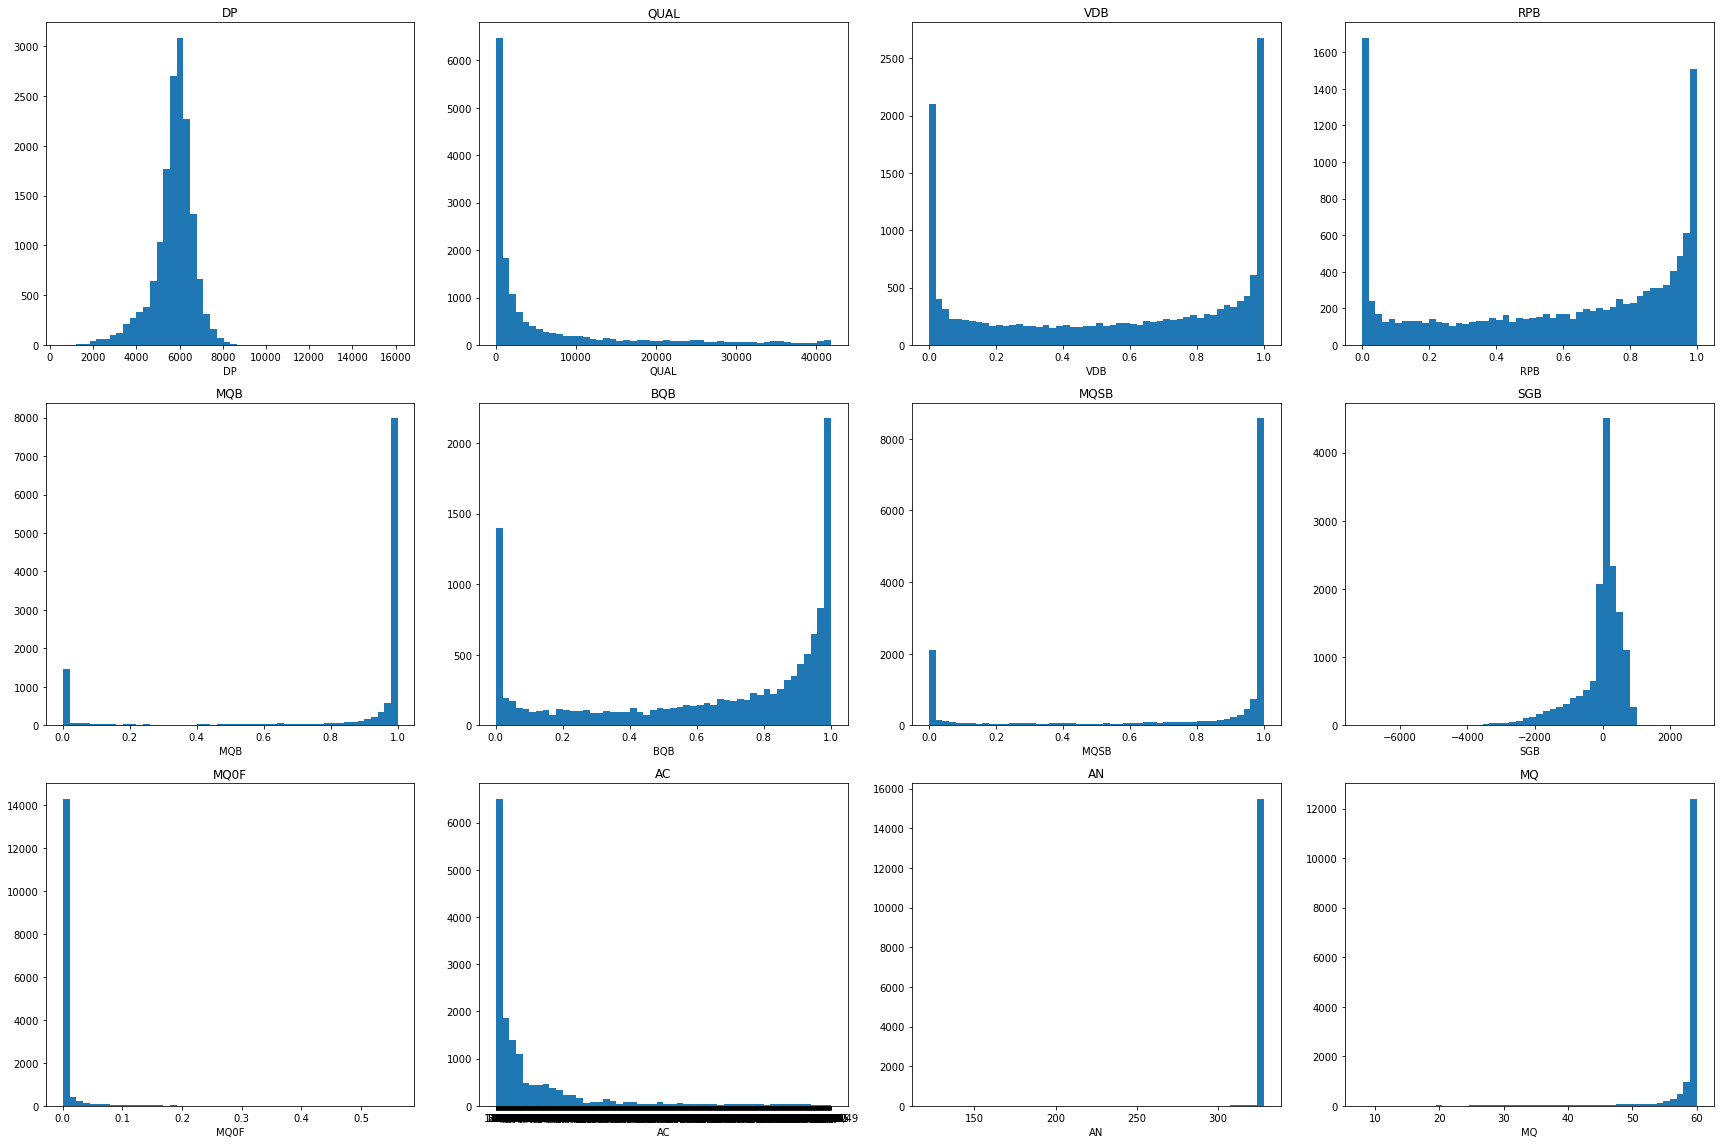

In [10]:
fig, axs = plt.subplots(figsize=(24,16), nrows=3, ncols=4)

for i, f in enumerate(field_title_dict.keys()):
    _ = axs[i//4,i%4].hist(info[f], 50)
    _ = axs[i//4,i%4].set_xlabel(f.upper())
    axs[i//4,i%4].set_title(f.upper())

plt.tight_layout()

plt.savefig(f'{plot_dir}/GWD_30x_calls.vcf.variant_info.png',dpi=300)

### 1.3 Set cutoffs

In [11]:
include_variants_dict = {
    'dp': ('>', 1000), #'Raw read depth'
    'qual': ('>', 50), #'Phred-scaled quality score for the assertion made in ALT',
    'vdb': ('>', 0), #'Variant Distance Bias for filtering splice-site artefacts in RNA-seq data\n(bigger is better)',
    'rpb': ('>', 0), # 'Mann-Whitney U test of Read Position Bias\n(bigger is better)',
    'mqb': ('>', 0), #'Mann-Whitney U test of Mapping Quality Bias\n(bigger is better)',
    'bqb': ('>', 0), #'Mann-Whitney U test of Base Quality Bias\n(bigger is better)',
    'mqsb': ('>', 0), #'Mann-Whitney U test of Mapping Quality vs Strand Bias\n(bigger is better)',
    # NOT SURE WHICH WAY TO FILTER ON SGB
    'sgb': ('', None), #'Segregation based metric',
    'mq0f': ('<', 0.1), #'Fraction of MQ0 reads\n(smaller is better)',
    'ac': ('', None), #'Allele count in genotypes for each ALT allele, in the same order as listed',
    'an': ('>', 300), #'Total number of alleles in called genotypes',
    'mq': ('>', 40)#'Average mapping quality'
}

# String containing all the filter logic to be used by bcftools
logic = ' & '.join([f'{field.upper()}{equality}{threshold}' for field, (equality, threshold) in include_variants_dict.items() if threshold is not None])


### 1.4 Filter variants

##### **(Optional)** Filter variants in the Pandas DataFrame

In [12]:
for field, (equality, threshold) in include_variants_dict.items():
    if threshold is not None:
        if equality == '>':
            info[f'fail_{field}'] = info[field]<=threshold
        elif equality == '<':
            info[f'fail_{field}'] = info[field]>=threshold
            
fail_columns = [c for c in info.columns if 'fail_' in c]

In [13]:
secretor_position=48703417
assert (info.loc[info.pos==secretor_position, fail_columns].values==False).all()


Make UpSet plot to see which filters remove variants

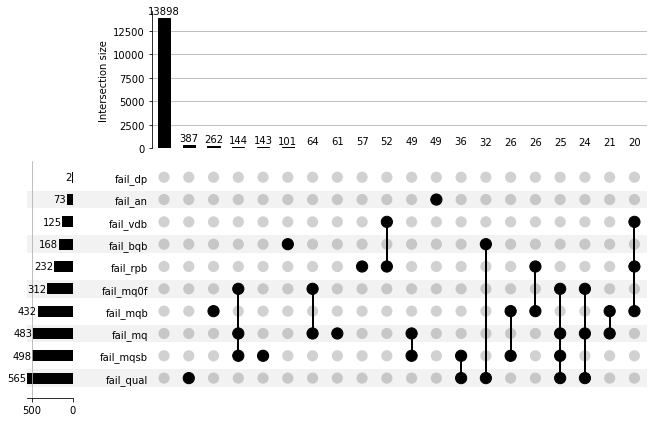

In [14]:
fail = info[[c for c in info.columns if 'fail_' in c]]
upset_format = from_indicators(fail.columns, fail)
UpSet(upset_format, min_subset_size=20, sort_by='cardinality', show_counts=True)

**Question: What happens when you change `min_subset_size`?**

**Question: Try changing thresholds in `include_variants_dict` to see what happens to the UpSet plot**

#### 1.4.1 Filter VCF using set cutoffs

Use bcftools to filter and save to a new VCF

In [15]:
%%bash -s "$data_dir" "$logic" "$qced_ref"

data_dir=$1
logic=$2
qced_ref=$3

raw_ref="${data_dir}/GWD_30x_calls.vcf.gz"


original_ct=$( bcftools view -H -G ${raw_ref} | wc -l )

bcftools filter ${raw_ref} \
  -Oz \
  -i "${logic}" \
  -o ${qced_ref} \
&& filtered_ct=$( bcftools view -G -H ${qced_ref} | wc -l ) \
|| ( echo "Failed." && exit 1 )

if [ $? == 0 ]; then
    echo ">> Variant counts <<"
    echo -e "original $original_ct"
    echo -e "post-qc  $filtered_ct"
    echo -e "removed  $(( original_ct - filtered_ct ))"
fi

>> Variant counts <<
original 15683
post-qc  10976
removed  4707


# 2. Phase 1000G VCF

Download genetic map from
https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz

In [16]:
%%bash -s "$data_dir"

data_dir=$1

if [ ! -f "${data_dir}/genetic_map_hg38_withX.txt.gz" ]; then
    url="https://storage.googleapis.com/broad-alkesgroup-public/Eagle/downloads/tables/genetic_map_hg38_withX.txt.gz"
    wget ${url} \
      --directory-prefix ${data_dir} \
      --no-verbose
fi

**Question: Try running the following cell. What happens?**

In [20]:
%%bash -s "$data_dir" "$qced_ref" "$phased_ref_prefix"

data_dir=$1
qced_ref=$2
phased_ref_prefix=$3


geneticMapFile="${data_dir}/genetic_map_hg38_withX.txt.gz"

eagle \
  --geneticMapFile ${geneticMapFile} \
  --vcf ${qced_ref} \
  --numThreads 5 \
  --outPrefix ${phased_ref_prefix} \
|| echo 'Failed.'
  

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.3.5              |
                      |   August 2, 2017            |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2016 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

eagle \
    --geneticMapFile /home/jovyan/data_test/genetic_map_hg38_withX.txt.gz \
    --vcf /home/jovyan/data_test/GWD_30x_calls.qced.vcf.gz \
    --numThreads 5 \
    --outPrefix /home/jovyan/data_test/GWD_30x_calls.phased 

Setting number of threads to 5

=== Reading genotype data ===

Reading genotypes for N = 164 samples


ERROR: Multi-allelic site found (i.e., ALT contains multiple alleles)
       Either drop or split (bcftools norm -m) multi-allelic variants


Failed.


Split multiallelic sites before running Eagle

In [21]:
%%bash -s "$qced_ref" "$split_ref"

qced_ref=$1
split_ref=$2

bcftools norm -m - ${qced_ref} \
  -Oz \
  -o ${split_ref}

Lines   total/split/realigned/skipped:	10976/55/0/0


In [22]:
%%bash -s "$data_dir" "$split_ref" "$phased_ref_prefix"

data_dir=$1
split_ref=$2
phased_ref_prefix=$3

geneticMapFile="${data_dir}/genetic_map_hg38_withX.txt.gz"

eagle \
  --geneticMapFile ${geneticMapFile} \
  --vcf ${split_ref} \
  --numThreads 5 \
  --outPrefix ${phased_ref_prefix}
  

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.3.5              |
                      |   August 2, 2017            |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2016 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

eagle \
    --geneticMapFile /home/jovyan/data_test/genetic_map_hg38_withX.txt.gz \
    --vcf /home/jovyan/data_test/GWD_30x_calls.split.vcf.gz \
    --numThreads 5 \
    --outPrefix /home/jovyan/data_test/GWD_30x_calls.phased 

Setting number of threads to 5

=== Reading genotype data ===

Reading genotypes for N = 164 samples
Read M = 11031 variants
Filling in genetic map coordinates using reference file:
  /home/jovyan/data_test/genetic_map_hg38_withX.txt.gz
Physical distance range: 1110053 

**Question: How does phasing change the genotypes in the VCFs?**

In [23]:
%%bash -s "$qced_ref"

qced_ref=$1

# Phased VCF
bcftools view -H ${qced_ref} | head -20 | cut -f 10-12

0/0:0,69,255	0/1:217,0,181	0/0:0,81,255
1/1:255,111,0	1/1:255,108,0	1/1:255,105,0
0/0:0,99,255	0/0:0,102,255	0/0:0,111,255
0/0:0,108,255	0/0:0,117,255	0/0:0,102,255
0/0:0,102,255	0/0:0,99,255	0/0:0,96,255
0/0:0,114,255	0/0:0,87,255	0/0:0,111,255
0/0:0,120,255	0/0:0,99,255	0/0:0,93,255
0/0:0,120,255	0/1:181,0,250	0/0:0,117,255
0/0:0,75,255	0/0:0,123,255	0/0:0,120,255
0/0:0,93,255	0/0:0,108,255	0/0:0,141,255
0/0:0,84,255	0/0:0,93,255	0/0:0,102,255
0/0:0,114,255	0/1:219,0,239	0/0:0,111,255
0/1:254,0,203	0/0:0,154,255	0/0:0,111,255
0/0:0,108,255	0/0:0,151,255	0/0:0,111,255
1/1:255,81,0	0/1:243,0,183	1/1:255,102,0
1/1:255,99,0	0/0:0,138,255	0/1:255,0,221
0/0:0,105,255	0/0:0,141,255	0/0:0,141,255
0/0:0,96,255	0/0:0,111,255	0/0:0,105,255
0/0:0,87,255	0/0:0,111,255	0/0:0,111,255
0/0:0,84,255	0/1:255,0,187	0/0:0,114,255


In [24]:
%%bash -s "$phased_ref"

phased_ref=$1

# Phased VCF
bcftools view -H ${phased_ref} | head -20 | cut -f 10-12

0|0:0,69,255	1|0:217,0,181	0|0:0,81,255
1|1:255,111,0	1|1:255,108,0	1|1:255,105,0
0|0:0,99,255	0|0:0,102,255	0|0:0,111,255
0|0:0,108,255	0|0:0,117,255	0|0:0,102,255
0|0:0,102,255	0|0:0,99,255	0|0:0,96,255
0|0:0,114,255	0|0:0,87,255	0|0:0,111,255
0|0:0,120,255	0|0:0,99,255	0|0:0,93,255
0|0:0,120,255	1|0:181,0,250	0|0:0,117,255
0|0:0,75,255	0|0:0,123,255	0|0:0,120,255
0|0:0,93,255	0|0:0,108,255	0|0:0,141,255
0|0:0,84,255	0|0:0,93,255	0|0:0,102,255
0|0:0,114,255	1|0:219,0,239	0|0:0,111,255
1|0:254,0,203	0|0:0,154,255	0|0:0,111,255
0|0:0,108,255	0|0:0,151,255	0|0:0,111,255
1|1:255,81,0	0|1:243,0,183	1|1:255,102,0
1|1:255,99,0	0|0:0,138,255	0|1:255,0,221
0|0:0,105,255	0|0:0,141,255	0|0:0,141,255
0|0:0,96,255	0|0:0,111,255	0|0:0,105,255
0|0:0,87,255	0|0:0,111,255	0|0:0,111,255
0|0:0,84,255	1|0:255,0,187	0|0:0,114,255


# 3. QC GGVP VCF

Set up paths

In [25]:
ggvp_prefix = 'GGVP-illumina_omni2.5M'
raw_target=f'{data_dir}/{ggvp_prefix}.vcf.gz' 
qced_target=f'{data_dir}/{ggvp_prefix}.qced.vcf.gz'

# TODO: Split the QCed VCF and point to it
# Currently points to QCed target
split_target=qced_target

phased_target_prefix=f'{data_dir}/{ggvp_prefix}.phased'
phased_target=f'{phased_target_prefix}.vcf.gz'

imputed_target_prefix=f'{data_dir}/{ggvp_prefix}.imputed'
imputed_target=f'{imputed_target_prefix}.dose.vcf.gz'
imputed_info=f'{imputed_target_prefix}.variant_info.tsv'

### 3.0 **(Optional)** Print VCF fields

In [26]:
%%bash -s "$raw_target"

raw_target=$1

bcftools view -h ${raw_target} | grep "^##.*INFO\|^##FORMAT"

# NOTE
# QUAL - Phred-scaled quality score for the assertion made in ALT. 
# See https://samtools.github.io/hts-specs/VCFv4.1.pdf

##FORMAT=<ID=GT,Type=String,Number=1,Description="Genotype call">
##FORMAT=<ID=XY,Type=Float,Number=R,Description="Normalised X and Y channel intensities">


Run simple variant QC on target VCF.

Keep variants with:
- Genotypes defined in >90% of samples
- MAF > 0.01


In [27]:
%%bash -s "$data_dir" "$raw_target" "$qced_target"

data_dir=$1
raw_target=$2
qced_target=$3

original_ct=$( bcftools view -H -G ${raw_target} | wc -l )

# Variant QC:
# Keep variants if 
# - GT is defined in >90% of samples
# - MAF > 0.01
# Includes step to replace "19" with "chr19"
bcftools view ${raw_target} \
  | sed 's/^19/chr19/g;s/##contig=<ID=19,/##contig=<ID=chr19,/g' \
  | bcftools filter \
  -i "(F_PASS(GT!='mis') > 0.9) && MAF>0.01" \
  -Oz \
  -o ${qced_target} \
&& filtered_ct=$( bcftools view -G -H ${qced_target} | wc -l ) \
|| ( echo "Failed." && exit 1 )

if [ $? == 0 ]; then
    echo ">> Variant counts <<"
    echo -e "original $original_ct"
    echo -e "post-qc  $filtered_ct"
    echo -e "removed  $(( original_ct - filtered_ct ))"
fi
    

>> Variant counts <<
original 1022
post-qc  813
removed  209


## 4. Phase GGVP VCF

In [28]:
%%bash -s "$data_dir" "$qced_target" "$phased_target_prefix"

data_dir=$1
qced_target=$2
phased_target_prefix=$3

genetic_map="${data_dir}/genetic_map_hg38_withX.txt.gz"

eagle \
  --geneticMapFile ${genetic_map} \
  --vcf ${qced_target} \
  --numThreads 5 \
  --outPrefix ${phased_target_prefix} 
  

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.3.5              |
                      |   August 2, 2017            |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2016 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

eagle \
    --geneticMapFile /home/jovyan/data_test/genetic_map_hg38_withX.txt.gz \
    --vcf /home/jovyan/data_test/GGVP-illumina_omni2.5M.qced.vcf.gz \
    --numThreads 5 \
    --outPrefix /home/jovyan/data_test/GGVP-illumina_omni2.5M.phased 

Setting number of threads to 5

=== Reading genotype data ===

Reading genotypes for N = 407 samples
Read M = 813 variants
Filling in genetic map coordinates using reference file:
  /home/jovyan/data_test/genetic_map_hg38_withX.txt.gz
Physical distance 

Time for phasing batch: 0.303244

BATCH 2 OF 10

Phasing samples 41-81
Time for phasing batch: 0.284497

BATCH 3 OF 10

Phasing samples 82-122
Time for phasing batch: 0.288133

BATCH 4 OF 10

Phasing samples 123-162
Time for phasing batch: 0.239244

BATCH 5 OF 10

Phasing samples 163-203
Time for phasing batch: 0.236485

BATCH 6 OF 10

Phasing samples 204-244
Time for phasing batch: 0.241047

BATCH 7 OF 10

Phasing samples 245-284
Time for phasing batch: 0.229609

BATCH 8 OF 10

Phasing samples 285-325
Time for phasing batch: 0.243886

BATCH 9 OF 10

Phasing samples 326-366
Time for phasing batch: 0.25093

BATCH 10 OF 10

Phasing samples 367-407
Time for phasing batch: 0.219512

Time for PBWT iter 1: 2.53664

BEGINNING PBWT ITER 2

BATCH 1 OF 10

Phasing samples 1-40


Time for phasing batch: 0.34255

BATCH 2 OF 10

Phasing samples 41-81
Time for phasing batch: 0.31603

BATCH 3 OF 10

Phasing samples 82-122
Time for phasing batch: 0.283515

BATCH 4 OF 10

Phasing samples 123-162
Time for phasing batch: 0.263843

BATCH 5 OF 10

Phasing samples 163-203
Time for phasing batch: 0.248749

BATCH 6 OF 10

Phasing samples 204-244
Time for phasing batch: 0.269162

BATCH 7 OF 10

Phasing samples 245-284
Time for phasing batch: 0.257244

BATCH 8 OF 10

Phasing samples 285-325
Time for phasing batch: 0.253152

BATCH 9 OF 10

Phasing samples 326-366
Time for phasing batch: 0.305514

BATCH 10 OF 10

Phasing samples 367-407
Time for phasing batch: 0.278473

Time for PBWT iter 2: 2.81826
Writing vcf.gz output to /home/jovyan/data_test/GGVP-illumina_omni2.5M.phased.vcf.gz
Time for writing output: 0.727579
Total elapsed time for analysis = 12.1486 sec


# 5. Impute GGVP VCF

Process reference haplotypes into M3VCF format using Minimac3

In [29]:
%%bash -s "$phased_ref" "$phased_ref_prefix"

phased_ref=$1
phased_ref_prefix=$2

# NOTE: We need to manually specify "chr19" because Minimac doesn't like 
# the "chr" prefix in front of GRCh38 chromosomes
Minimac3 \
  --refHaps ${phased_ref} \
  --processReference \
  --prefix ${phased_ref_prefix} \
  --chr "chr19"



 -------------------------------------------------------------------------------- 
          Minimac3 - Fast Imputation Based on State Space Reduction HMM
 --------------------------------------------------------------------------------
           (c) 2014 - Sayantan Das, Christian Fuchsberger, David Hinds
                             Mary Kate Wing, Goncalo Abecasis 

 Version: 2.0.1;
 Built: Tue Jun  7 19:11:01 EDT 2016 by sayantan

 Command Line Options: 
    Reference Haplotypes : --refHaps [/home/jovyan/data_test/GWD_30x_calls.phased.vcf.gz],
                           --passOnly, --rsid
       Target Haplotypes : --haps []
       Output Parameters : --prefix [/home/jovyan/data_test/GWD_30x_calls.phased],
                           --processReference [ON], --updateModel, --nobgzip,
                           --vcfOutput [ON], --doseOutput, --hapOutput,
                           --format [GT,DS], --allTypedSites
       Subset Parameters : --chr [chr19], --start, --end, --window


Impute with Minimac4

In [30]:
%%bash -s "$data_dir" "$phased_ref_prefix" "$phased_target" "$imputed_target_prefix"

data_dir=$1
phased_ref_prefix=$2
phased_target=$3
imputed_target_prefix=$4

genetic_map="${data_dir}/genetic_map_hg38_withX.txt.gz"

minimac4 \
  --refHaps "${phased_ref_prefix}.m3vcf.gz" \
  --mapFile ${genetic_map} \
  --haps ${phased_target} \
  --ignoreDuplicates \
  --format GT \
  --prefix ${imputed_target_prefix}
  



 -------------------------------------------------------------------------------- 
          Minimac4 - Fast Imputation Based on State Space Reduction HMM
 --------------------------------------------------------------------------------
           (c) 2014 - Sayantan Das, Christian Fuchsberger, David Hinds
                             Mary Kate Wing, Goncalo Abecasis 

 Version: 1.0.3;
 Built: Thu 16 Jun 2022 08:18:21 AM UTC by root

 Command Line Options: 
       Reference Haplotypes : --refHaps [/home/jovyan/data_test/GWD_30x_calls.phased.m3vcf.gz],
                              --passOnly, --rsid, --referenceEstimates [ON],
                              --mapFile [/home/jovyan/data_test/genetic_map_hg38_withX.txt.gz]
          Target Haplotypes : --haps [/home/jovyan/data_test/GGVP-illumina_omni2.5M.phased.vcf.gz]
          Output Parameters : --prefix [/home/jovyan/data_test/GGVP-illumina_omni2.5M.imputed],
                              --estimate, --nobgzip, --vcfBuffer [200],
 

# 6. Post-imputation checks

### 6.1 Check how many variants exist in the imputed data compared to the original

In [31]:
%%bash -s "$phased_target" "$imputed_target"

phased_target=$1
imputed_target=$2

pre_impute_ct=$( bcftools view -H ${phased_target} | wc -l )
post_impute_ct=$( bcftools view -H ${imputed_target} | wc -l )

echo ">> Variant count <<"
echo "pre-impute  ${pre_impute_ct}"
echo "post-impute ${post_impute_ct}"

>> Variant count <<
pre-impute  813
post-impute 11031


### 6.2 Check that secretor status variant

Check that secretor status variant was not in the pre-imputation target data

In [32]:
%%bash -s "$raw_target"

raw_target=$1

bcftools view -H -i 'POS=48703417' "${raw_target}"

# No output because variant with position 48703417 does not exist in VCF

Check that secretor status variant is in the imputed target data

In [33]:
%%bash -s "$phased_target" "$imputed_target"

phased_target=$1
imputed_target=$2

bcftools view -H -i 'POS=48703417' ${imputed_target}

chr19	48703417	chr19:48703417:G:A	G	A	.	PASS	AF=0.53395;MAF=0.46605;R2=0.99822;IMPUTED	GT	0|0	1|0	1|0	1|1	0|1	1|0	0|0	1|1	0|0	0|1	0|1	1|0	0|1	0|1	0|0	1|1	1|1	1|0	0|1	1|1	0|0	0|0	1|0	1|1	0|0	0|1	0|0	1|1	0|0	1|0	0|0	1|1	0|1	0|1	0|0	1|1	1|0	1|1	1|1	0|0	1|0	0|0	0|1	1|0	1|0	1|1	0|0	0|0	1|0	0|1	0|0	0|0	0|1	0|0	0|1	0|1	1|0	1|1	0|1	1|1	1|1	1|0	1|1	0|0	0|1	1|0	0|0	1|0	1|1	1|0	0|0	1|0	0|1	0|1	1|1	1|0	1|1	0|0	0|1	0|0	0|1	0|1	1|0	1|1	0|0	1|0	0|1	0|1	1|0	1|1	1|0	0|0	1|0	1|0	0|0	1|1	1|1	1|0	1|0	1|0	0|1	1|1	1|1	1|0	0|0	0|1	0|1	0|0	1|1	0|0	1|1	1|1	0|0	1|0	1|0	0|1	1|0	1|1	1|1	0|1	1|0	0|1	1|1	1|1	1|1	1|1	1|0	0|0	1|0	0|1	1|0	1|0	1|0	0|1	1|1	0|1	1|1	0|1	0|1	0|0	0|1	1|0	0|0	1|0	1|1	0|0	1|1	0|0	0|1	1|1	0|1	0|1	0|1	1|1	0|1	0|0	0|1	1|0	0|1	0|0	1|1	1|0	0|0	1|0	1|0	1|0	1|1	1|1	1|0	1|1	1|0	1|1	1|1	1|0	1|1	1|0	1|0	1|0	1|1	1|1	0|0	0|1	0|1	0|1	1|1	0|1	1|1	1|1	0|1	0|0	0|0	0|0	1|1	0|1	0|0	1|1	1|1	1|0	1|0	1|1	0|1	0|1	1|1	1|0	1|0	1|1	1|1	1|0	0|0	0|0	1|0	1|0	0|1	1|1	0|1	0|1	1|1	1|0	1|1	0|0	1|1	0|0	1|1	1|1	1|0	0|0	1|1	1|

### 6.3 Print fields in imputed VCF

In [34]:
%%bash -s "$imputed_target"

imputed_target=$1

bcftools view -h ${imputed_target} | grep "^##.*INFO\|^##FORMAT"

# NOTE
# QUAL - Phred-scaled quality score for the assertion made in ALT. 
# See https://samtools.github.io/hts-specs/VCFv4.1.pdf

##INFO=<ID=AF,Number=1,Type=Float,Description="Estimated Alternate Allele Frequency">
##INFO=<ID=MAF,Number=1,Type=Float,Description="Estimated Minor Allele Frequency">
##INFO=<ID=R2,Number=1,Type=Float,Description="Estimated Imputation Accuracy (R-square)">
##INFO=<ID=ER2,Number=1,Type=Float,Description="Empirical (Leave-One-Out) R-square (available only for genotyped variants)">
##INFO=<ID=IMPUTED,Number=0,Type=Flag,Description="Marker was imputed but NOT genotyped">
##INFO=<ID=TYPED,Number=0,Type=Flag,Description="Marker was genotyped AND imputed">
##INFO=<ID=TYPED_ONLY,Number=0,Type=Flag,Description="Marker was genotyped but NOT imputed">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">


### 6.4 Extract fields from VCF

In [35]:
%%bash -s "$data_dir" "$imputed_target" "$imputed_info"

data_dir=$1
imputed_target=$2
imputed_info=$3

bcftools query -f '%AF\t%MAF\t%R2\t%ER2\t%IMPUTED\t%TYPED\t%TYPED_ONLY\n' ${imputed_target} > ${imputed_info}

In [36]:
info = pd.read_csv(
    imputed_info, 
    sep='\t', 
    names=['af','maf','r2','er2','imputed','typed','typed_only'],
    na_values=['.']
)

**Question: Is there any relation between MAF and imputation accuracy?**

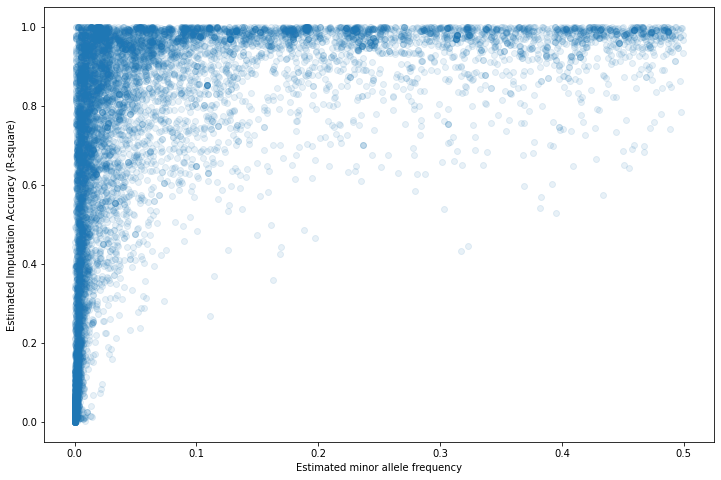

In [37]:
plt.figure(figsize=(12,8))
plt.scatter(info.maf, info.r2, alpha=0.1)
plt.xlabel('Estimated minor allele frequency')
_ = plt.ylabel('Estimated Imputation Accuracy (R-square)')

**Question: What is the average R2 for all imputed variants?**

In [38]:
print(f'Average R2 for variants that are genotyped and imputed: {info.r2.mean()}')

Average R2 for variants that are genotyped and imputed: 0.7106065551627232


#### 6.4.1 Genotyped and imputed variants

Filter to genotyped and imputed variants

In [39]:
typed_and_imputed = info[~info.typed.isna()]

**Question: Plot MAF vs. R2 for variants that are genotyped AND imputed**

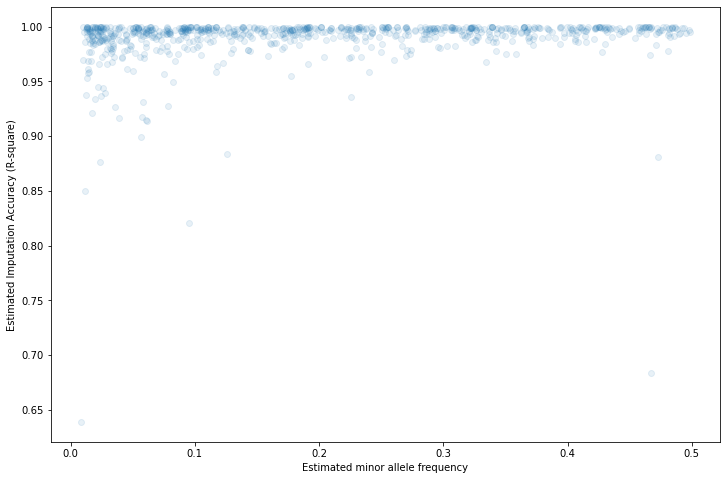

In [40]:
plt.figure(figsize=(12,8))
plt.scatter(typed_and_imputed.maf, typed_and_imputed.r2, alpha=0.1)
plt.xlabel('Estimated minor allele frequency')
_ = plt.ylabel('Estimated Imputation Accuracy (R-square)')

**Question: What is the average R2 for variants that were genotyped AND imputed?**

In [41]:
print(f'Average R2 for variants that are genotyped and imputed: {typed_and_imputed.r2.mean()}')

Average R2 for variants that are genotyped and imputed: 0.9900559924146649
